In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, coo_matrix
from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis

In [41]:
np.random.seed(1)

In [42]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [43]:
#tree = make_tree([3,3,3])
tree = make_tree([3,3])

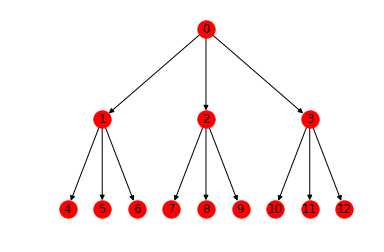

In [44]:
nice_tree_plot(tree)

## Extracting a tree from simulated data

In [45]:
num_docs = 50000
words_per_doc = 20
vocab_size = 100
topic_dirichlet = 0.1

In [46]:
def topic_func(node_id):
    topic = np.ones(vocab_size)
    topic[node_id % vocab_size] = 20.0
    topic /= topic.sum()
    return topic

#topic_func = None  # Use this line to use random topics instead

In [47]:
sampler = HPAM2Sampler(
    g = tree,
    num_docs = num_docs,
    words_per_doc = words_per_doc,
    vocab_size = vocab_size,
    topic_dirichlet = topic_dirichlet,
    topic_func = topic_func)

In [48]:
%%time
sampler.sample(); None

100%|██████████| 50000/50000 [01:51<00:00, 447.28it/s]

CPU times: user 1min 47s, sys: 9.17 s, total: 1min 56s
Wall time: 1min 51s


In [49]:
%%time
data = lil_matrix((sampler.num_docs, sampler.vocab_size), dtype='float')
for doc_index, doc in enumerate(tqdm.tqdm(sampler.docs)):
    doc = sorted(doc)
    for vocab_index in doc:
        data[doc_index, vocab_index] += 1
data = csr_matrix(data)

100%|██████████| 50000/50000 [00:09<00:00, 5217.64it/s]


CPU times: user 9.5 s, sys: 228 ms, total: 9.72 s
Wall time: 9.91 s


In [50]:
num_digits = len(str(sampler.vocab_size - 1))
vocab = ["w{:0{}d}".format(i, num_digits) for i in range(sampler.vocab_size)]

In [51]:
K = len(tree.nodes())

In [52]:
analysis = Analysis(
    infile = data.transpose(),
    vocab_file = vocab,
    outfile = None,
    loss = "L2",
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = min(int(num_docs * 0.05), 50),
    top_words = 10,
)

In [53]:
%%time
analysis.run();

Input matrix shape: (100, 50000)
identifying candidate anchors
100 candidates
Sum of entries in Q is  0.9999999999999853
Multiplying Q took  1.7634549140930176 seconds
Q sum is 0.9999999999999853
done reading documents
anchors are:
0 w00
1 w05
2 w10
3 w09
4 w01
5 w03
6 w08
7 w12
8 w07
9 w06
10 w11
11 w02
12 w04
begin threaded recovery with 8 processors
0	-1	1.0
done recovering
w00 : w00 w20 w54 w28 w88 w64 w45 w67 w86 w38 
w05 : w05 w95 w98 w55 w18 w33 w47 w65 w99 w66 
w10 : w10 w25 w53 w59 w69 w46 w84 w20 w68 w15 
w09 : w09 w18 w91 w84 w70 w69 w67 w19 w99 w20 
w01 : w01 w42 w77 w94 w68 w59 w84 w69 w21 w83 
w03 : w03 w88 w91 w89 w95 w79 w23 w71 w56 w54 
w08 : w08 w38 w82 w32 w24 w21 w98 w97 w29 w17 
w12 : w12 w80 w70 w33 w90 w24 w79 w62 w81 w49 
w07 : w07 w94 w78 w67 w66 w50 w64 w14 w96 w49 
w06 : w06 w36 w19 w24 w22 w51 w83 w90 w92 w27 
w11 : w11 w37 w48 w71 w65 w92 w16 w27 w94 w77 
w02 : w02 w76 w34 w28 w62 w15 w40 w63 w36 w85 
w04 : w04 w72 w53 w48 w49 w61 w69 w43 w35 w64 
CPU times

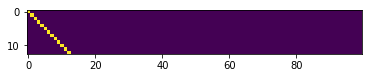

In [54]:
topics = np.array([sampler.topics[n] for n in tree.nodes()])
plt.imshow(topics);

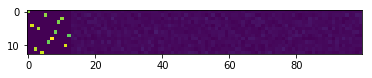

In [55]:
plt.imshow(analysis.A.T);

In [56]:
analysis.Q.shape

(100, 100)

In [57]:
analysis.A.sum(axis=0), analysis.A.sum(axis=1)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0.26480774, 0.29711385, 0.28028654, 0.27658392, 0.290547  ,
        0.26201692, 0.24511522, 0.31584677, 0.24837861, 0.2540321 ,
        0.26769164, 0.29708893, 0.24147079, 0.10971653, 0.11299858,
        0.1103594 , 0.10550671, 0.10719635, 0.10879471, 0.10735048,
        0.104118  , 0.10527073, 0.10577155, 0.10878165, 0.10311691,
        0.10934768, 0.10818927, 0.11029245, 0.10718727, 0.1094243 ,
        0.10955177, 0.11184437, 0.10834499, 0.10694132, 0.10997028,
        0.11023182, 0.1091631 , 0.1080407 , 0.1058375 , 0.11032343,
        0.10672362, 0.10748175, 0.10773753, 0.11161211, 0.10671951,
        0.10613315, 0.11004217, 0.11008049, 0.10800812, 0.10954953,
        0.11058642, 0.10658724, 0.10945768, 0.10848623, 0.10548664,
        0.10598658, 0.10961105, 0.10827014, 0.11060483, 0.11102165,
        0.10711546, 0.10981958, 0.10823578, 0.10864828, 0.10866335,
        0.11065166, 0.11233801, 0.10563253, 0.10998717

In [69]:
R = analysis.R

In [70]:
# # Undo per-row normalization? (convert conditional -> non-conditional matrix)
# R = R.copy() * analysis.topic_likelihoods[:, np.newaxis]

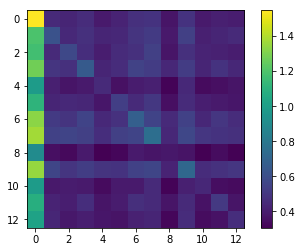

In [71]:
fig, ax = plt.subplots()
ax.imshow(R);
fig.colorbar(ax.get_images()[0]);

In [72]:
np.max(np.abs(R - R.T))

0.8841285498669085

In [73]:
R.min(), R.max()

(0.30591880696795315, 1.547004017900554)

In [74]:
R.sum()

85.19257687057393

In [75]:
C = Aho.get_ratio_matrix(R)

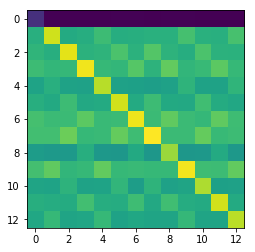

In [76]:
plt.imshow(C);

In [77]:
extracted_tree = Aho.extract(C)

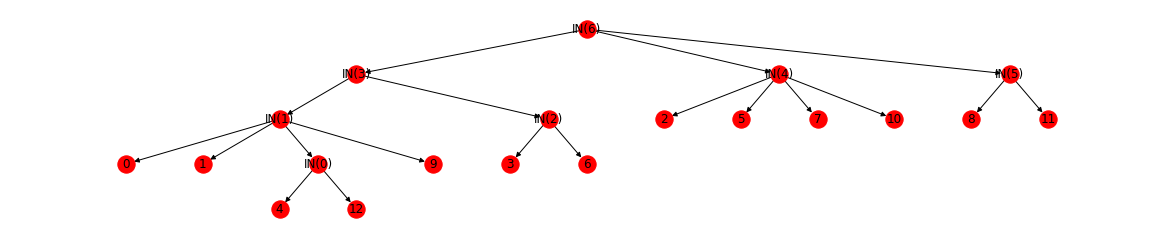

In [78]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

* TODO: extract tree from real data
* TODO: run the tree-building sequence on the above results

In [68]:
# incorrect topics?  (how to map recovered topics onto "expected" topics?)
#   - topics with too much overlap?  try sparser dirichlet?
# or: correct topics but noisy R estimation?  (throwing away too many triplets??)